In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
#dont keep api key in github!!!
api_file = os.path.join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())
    
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes',itemizedonly = True)
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 

## Input pipeline for tfrecord data

In [3]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "radiant_win" :tf.FixedLenFeature([], dtype=tf.int64),
        "gold_diff": tf.FixedLenFeature([], dtype=tf.float32)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    radiant_heroes = tf.decode_raw(parsed_features['radiant_heroes'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']

    return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
            {'radiant_win':radiant_win, 'gold_diff':gold_diff}

In [4]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True,
              batch_size=50,compression_type=""):
   
    #create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames, compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.batch(batch_size)
    ds = ds.repeat(num_epochs)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [5]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data','mixed_skill',
                                          'dota2_training_data',
                                          'dual_gold_win_dota2_training_data.tfrecords'),
                            compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function)
ds = ds.shuffle(10000)
ds

<DatasetV1Adapter shapes: ({radiant_heroes: (?,), dire_heroes: (?,)}, {radiant_win: (), gold_diff: ()}), types: ({radiant_heroes: tf.int64, dire_heroes: tf.int64}, {radiant_win: tf.int64, gold_diff: tf.float32})>

In [43]:
ds = ds.shuffle(10000)
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'radiant_heroes': array([ 74,  10,  21, 129,  14]),
  'dire_heroes': array([70,  4, 50, 17,  9])},
 {'radiant_win': 0, 'gold_diff': -1.2938595})

# Define and train dual head linear (or dnn) model

### Define feature column constructor functions

In [7]:
def construct_hero_categorical_columns(keys,vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])                                                               

In [8]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns      

In [9]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

## Define model function

### Define model function for soft parameter sharing

In [10]:
# In `dual_head_model`, specify logits as a dict keyed by head name:
def dual_head_model(features, labels, mode, params):
    """Estimator for a dual binary classifier and regressor. 
    The loss is a linear combination of the softmax cross entropy
    of the classifier and the huber loss of the regressor.
    
    Args:
        features: `dict` batch_features from an input_fn.
        labels: `dict` of batch_labels for win from an input_fn.
        mode: `str` specifying tf.Estimator mode (e.g. Train, Eval, Predict).
        params: `dict` of params with elements: feature_columns, hidden_units_gold,
                    hidden_units_win, win_loss_weight.
            feature_columns: A `set` specifying the input feature columns to use.
            optimizer: A `tf.train.Optimizer` to use
            hidden_units_gold: A `list` of `int`s for layer sizes for gold dnn. 
                    An empty list makes a linear model.
            hidden_units_win: A `list` of `int` for the win dnn.
            win_loss_weight: `float` Weight from [0,1] for the win_loss 
                    relative to the gold_loss (weighted as 1-win_loss_weight).

    returns: 
        A tf.estimator object
    """

    #initialize net_gold and net_win as the input_layer
    net_gold = tf.feature_column.input_layer(features, params['feature_columns'])
    net_win = tf.feature_column.input_layer(features, params['feature_columns'])

    # Build the hidden layers, sized according to the 'hidden_units' param.
    # if hidden units is empty then no dense layers (and it is just linear regression)
    layer_list_gold =[]
    layer_list_win=[]
    for units in params['hidden_units']:
        layer_list.append(tf.layers.Dense(units=units, activation=tf.nn.relu))
        net_gold = layer_list_gold[-1](net_gold)
        layer_list_win.append(tf.layers.Dense(units=units, activation=tf.nn.relu))
        net_win = layer_list_win[-1](net_win)  
     # Compute logits gold (1 because it is just the predicted diff).
    logits_gold = tf.layers.dense(net_gold, 1, activation=None,
                                  trainable=True, name='output_gold')
    # Compute logits win (win or lose).
    logits_win = tf.layers.dense(net_win, 2, activation=None, 
                                 trainable=True, name='output_win')

    #collect logits into a single dict
    logits = {'gold_head':logits_gold, 'win_head':logits_win}
    
    # Compute predictions.
    predicted_win = tf.argmax(logits['win_head'], 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'classes': predicted_things[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits['win_head']),
            'logits_win': logits['win_head'],
            'gold': logits['gold_head']
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Compute loss.
    labels['radiant_win'] = tf.one_hot(labels['radiant_win'],2)
    win_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels['radiant_win'],
                                               logits=logits['win_head'])
    gold_loss = tf.losses.huber_loss(labels=labels['gold_diff'],
                                     predictions=tf.reshape(logits['gold_head'],[-1]))
    
    #Scale loss_win to weight it more heavily or equal to loss_gold
    #loss_gold starts at 1 because of the z_score normalization we did
    loss_weight=params['win_loss_weight']
    loss = tf.losses.compute_weighted_loss([win_loss,gold_loss],
                                                 weights=[loss_weight,1-loss_weight])
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(tf.gather(labels['radiant_win'],1,axis=1),
                                   predicted_win,
                                   name='acc_op')
    auc = tf.metrics.auc(tf.gather(labels['radiant_win'],1,axis=1),
                        predicted_win)
    baseline_accuracy = tf.metrics.mean(values=labels['radiant_win'])
    metrics = {'accuracy': accuracy,
               'auc': auc,
               'baseline_accuracy': baseline_accuracy}

    tf.summary.scalar('accuracy', accuracy[1])
    tf.summary.scalar('auc', auc[1])
    tf.summary.scalar('loss_win', win_loss)
    tf.summary.scalar('loss_gold', gold_loss)
    tf.summary.scalar('loss', loss)

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = params['optimizer']
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### Define model function for hard parameter sharing

In [50]:
# In `dual_head_model`, specify logits as a dict keyed by head name:
def dual_head_model_hardsharing(features, labels, mode, params):
    """Estimator for a dual binary classifier and regressor. 
    The loss is a linear combination of the softmax cross entropy
    of the classifier and the huber loss of the regressor.
    
    Args:
        features: `dict` batch_features from an input_fn.
        labels: `dict` of batch_labels for win from an input_fn.
        mode: `str` specifying tf.Estimator mode (e.g. Train, Eval, Predict).
        params: `dict` of params with elements: feature_columns, hidden_units_gold,
                    hidden_units_win, win_loss_weight.
            feature_columns: A `set` specifying the input feature columns to use.
            optimizer: A `tf.train.Optimizer` to use
            hidden_units: A `list` of `int`s for layer sizes for dnn. 
                    An empty list makes a linear model.
            win_loss_weight: `float` Weight from [0,1] for the win_loss 
                    relative to the gold_loss (weighted as 1-win_loss_weight).
    returns: 
        A tf.estimator object
    """

    #initialize net_gold and net_win as the input_layer
    net = tf.feature_column.input_layer(features, params['feature_columns'])

    # Build the hidden layers, sized according to the 'hidden_units' param.
    # if hidden units is empty then no dense layers (and it is just linear regression)
    layer_list =[]
    for units in params['hidden_units']:
        layer_list.append(tf.layers.Dense(units=units, activation=tf.nn.relu))
        net = layer_list[-1](net)
     # Compute logits gold (1 because it is just the predicted diff).
    logits_gold = tf.layers.dense(net, 1, activation=None,
                                  trainable=True, name='output_gold')
    # Compute logits win (win or lose).
    logits_win = tf.layers.dense(net, 2, activation=None, 
                                 trainable=True, name='output_win')

    #collect logits into a single dict
    logits = {'gold_head':logits_gold, 'win_head':logits_win}
    
    # Compute predictions.
    predicted_win = tf.argmax(logits['win_head'], 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'classes': predicted_things[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits['win_head']),
            'logits_win': logits['win_head'],
            'gold': logits['gold_head']
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Compute loss.
    labels['radiant_win'] = tf.one_hot(labels['radiant_win'],2)
    win_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels['radiant_win'],
                                               logits=logits['win_head'])
    gold_loss = tf.losses.huber_loss(labels=labels['gold_diff'],
                                     predictions=tf.reshape(logits['gold_head'],[-1]))
    
    #Scale loss_win to weight it more heavily or equal to loss_gold
    #loss_gold starts at 1 because of the z_score normalization we did
    loss_weight=params['win_loss_weight']
    loss = tf.losses.compute_weighted_loss([win_loss,gold_loss],
                                                 weights=[loss_weight,1-loss_weight])
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(tf.gather(labels['radiant_win'],1,axis=1),
                                   predicted_win,
                                   name='acc_op')
    auc = tf.metrics.auc(tf.gather(labels['radiant_win'],1,axis=1),
                        predicted_win)
    baseline_accuracy = tf.metrics.mean(values=labels['radiant_win'])
    metrics = {'accuracy': accuracy,
               'auc': auc,
               'baseline_accuracy': baseline_accuracy}

    tf.summary.scalar('accuracy', accuracy[1])
    tf.summary.scalar('auc', auc[1])
    tf.summary.scalar('loss_win', win_loss)
    tf.summary.scalar('loss_gold', gold_loss)
    tf.summary.scalar('loss', loss)

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = params['optimizer']
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### train function

In [35]:
def train_dual_classifier_regressor(
    steps,
    batch_size,
    params,
    training_file,
    validation_file,
    compression_type=""):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        target: Target to use for the model (determines whether float and classifier
          vs regressor)
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int` specifying the size of each training batch
        params: A dict containing kwargs
            optimizer: A `tf.train.Optimizer` to use
            hidden_units: A `list` of `int`s for layer sizes for dnn. 
                    An empty list makes a linear model.
        training_file: A `string` path to the tfrecord training file
        validation_file: A `string` path to the tfrecord validation file
        compression_type: A `string` specifying the type of compression of the
                    TFRecords

        
      
    Returns:
        A `LinearEstimator` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods
    
    # Create a linear regressor object.
    dual_model = tf.estimator.Estimator(
        model_fn=dual_head_model_hardsharing,
        params= params
        )
      
  
    training_input_fn =lambda: _input_fn([training_file], 
                                         compression_type=compression_type)
    validation_input_fn =lambda: _input_fn([validation_file],
                                          compression_type=compression_type)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    validation_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dual_model.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dual_model.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(evaluation_metrics['loss'])
                            
        evaluation_metrics = dual_model.evaluate(
            input_fn=validation_input_fn,
            steps=steps_per_period)    
        validation_acc.append(evaluation_metrics['loss'])
        
        print('validation loss', evaluation_metrics['loss'])

    print("Validation set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training loss')
    plt.plot(validation_acc,label='Validation loss')
    plt.legend()
    plt.show()
    
    return dual_model


### Train a dual head linear classifier and regressor

In [52]:
training_file = os.path.join('Dota_data','mixed_skill',
                             'dota2_training_data',
                             'dual_gold_win_dota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data','mixed_skill',
                               'dota2_validation_data', 
                               'dual_gold_win_dota2_validation_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['radiant_heroes',
                                                                  'dire_heroes'],
                                                                hero_vocab)
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,
                                                        dimension=4)

#### Test of radiant_win modelling with linear model

Training model...
validation loss 0.7119085
validation loss 0.7065336
validation loss 0.71067864
validation loss 0.70314217
validation loss 0.70342636
validation loss 0.69852316
validation loss 0.6976629
validation loss 0.6946579
validation loss 0.69535327
validation loss 0.6866873
validation loss 0.68987703
validation loss 0.6905968
validation loss 0.6878172
validation loss 0.68971395
validation loss 0.68833846
validation loss 0.69127244
validation loss 0.68224776
validation loss 0.6867959
validation loss 0.6873641
validation loss 0.68732834
Validation set metrics:
accuracy 0.5508
auc 0.5301366
baseline_accuracy 0.5
loss 0.68732834
global_step 1000
---


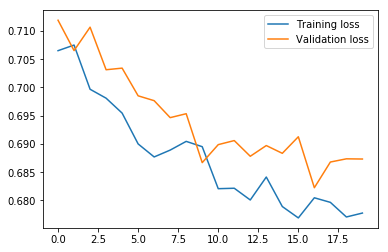

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=1e3,
    batch_size=5000,
    params={'hidden_units':[],
            'optimizer':optimizer,
            'feature_columns':indicator_feature_columns,
            'win_loss_weight':1
           },
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 0.6814898
validation loss 0.67604315
validation loss 0.67410207
validation loss 0.6750834
validation loss 0.6726319
validation loss 0.6735657
validation loss 0.673314
validation loss 0.67405254
validation loss 0.6733094
validation loss 0.6721369
validation loss 0.67429686
validation loss 0.6729048
validation loss 0.67266643
validation loss 0.6723436
validation loss 0.67400086
validation loss 0.67141074
validation loss 0.67427176
validation loss 0.6732321
validation loss 0.67280966
validation loss 0.6715519
Validation set metrics:
accuracy 0.58348
auc 0.5673834
baseline_accuracy 0.5
loss 0.6715519
global_step 10000
---


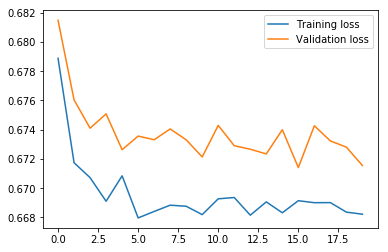

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=1e4,
    batch_size=5000,
    params={'hidden_units':[],
            'optimizer':optimizer,
            'feature_columns':indicator_feature_columns,
            'win_loss_weight':1
           },
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 0.6864844
validation loss 0.6759142
validation loss 0.6740468
validation loss 0.67387605
validation loss 0.67411786
validation loss 0.6734216
validation loss 0.67287415
validation loss 0.67288095
validation loss 0.6720452
validation loss 0.67304134
validation loss 0.6726419
validation loss 0.67286736
validation loss 0.67241156
validation loss 0.67294973
validation loss 0.67308754
validation loss 0.67351717
validation loss 0.6737289
validation loss 0.67303735
validation loss 0.6735255
validation loss 0.6729112
Validation set metrics:
accuracy 0.5824
auc 0.56584007
baseline_accuracy 0.5
loss 0.6729112
global_step 10000
---


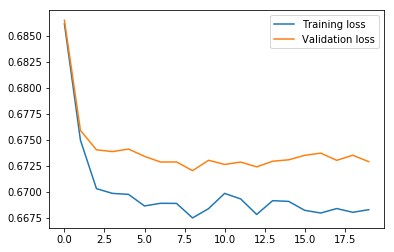

In [40]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0007)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=1e4,
    batch_size=10000,
    params={'hidden_units':[],
            'optimizer':optimizer,
            'feature_columns':indicator_feature_columns,
            'win_loss_weight':1
           },
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

#### Train single head gold_diff linear model to test

Training model...
validation loss 0.43765062
validation loss 0.42608696
validation loss 0.4201804
validation loss 0.41532204
validation loss 0.41405165
validation loss 0.41504833
validation loss 0.41682318
validation loss 0.4146256
validation loss 0.4135348
validation loss 0.4144442
validation loss 0.41574943
validation loss 0.41521287
validation loss 0.41727644
validation loss 0.4155105
validation loss 0.4140295
validation loss 0.4131161
validation loss 0.41509637
validation loss 0.41312122
validation loss 0.41201827
validation loss 0.41563052
Validation set metrics:
accuracy 0.49644
auc 0.50782937
baseline_accuracy 0.5
loss 0.41563052
global_step 10000
---


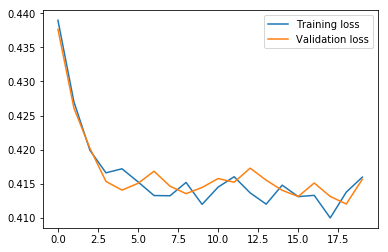

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=1e4,
    batch_size=5000,
    params={'hidden_units':[],
            'optimizer':optimizer,
            'feature_columns':indicator_feature_columns,
            'win_loss_weight':0
           },
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

#### Train multi-head dnn

Training model...
validation loss 0.30557752
validation loss 0.3051583
validation loss 0.3042283
validation loss 0.3026511
validation loss 0.30123368
validation loss 0.3003765
validation loss 0.29970348
validation loss 0.29910886
validation loss 0.29875213
validation loss 0.29834586
validation loss 0.29816505
validation loss 0.29804724
validation loss 0.29804444
validation loss 0.297902
validation loss 0.29795066
validation loss 0.29777938
validation loss 0.29782078
validation loss 0.29768744
validation loss 0.29781395
validation loss 0.29780316
Validation set metrics:
accuracy 0.5834627
auc 0.5684276
baseline_accuracy 0.5
loss 0.29780316
global_step 50000
---


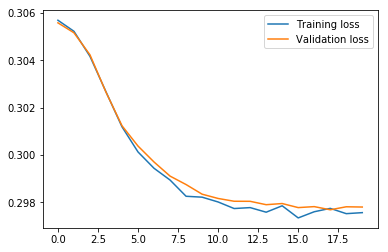

In [59]:
optimizer = tf.contrib.opt.AdamWOptimizer(learning_rate=20e-5,
                                          weight_decay =2e-5)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=5e4,
    batch_size=10000,
    params={'hidden_units':[8,8],
            'optimizer':optimizer,
            'feature_columns':embedding_feature_columns,
            'win_loss_weight':0.7
           },
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

### Test model
only do this if you're done training!!

In [295]:
test_file = os.path.join('dota2_data','mixed_skill',
                               'dota2_test_data', 
                               'dual_gold_win_dota2_test_data.tfrecords')
test_input_fn =lambda: _input_fn([test_file])
evaluation_metrics = trained_dualhead_linear_model.evaluate(
            input_fn=test_input_fn,
            steps=3e3)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

KeyboardInterrupt: 

### Investigate embeding layer

In [79]:
champ_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

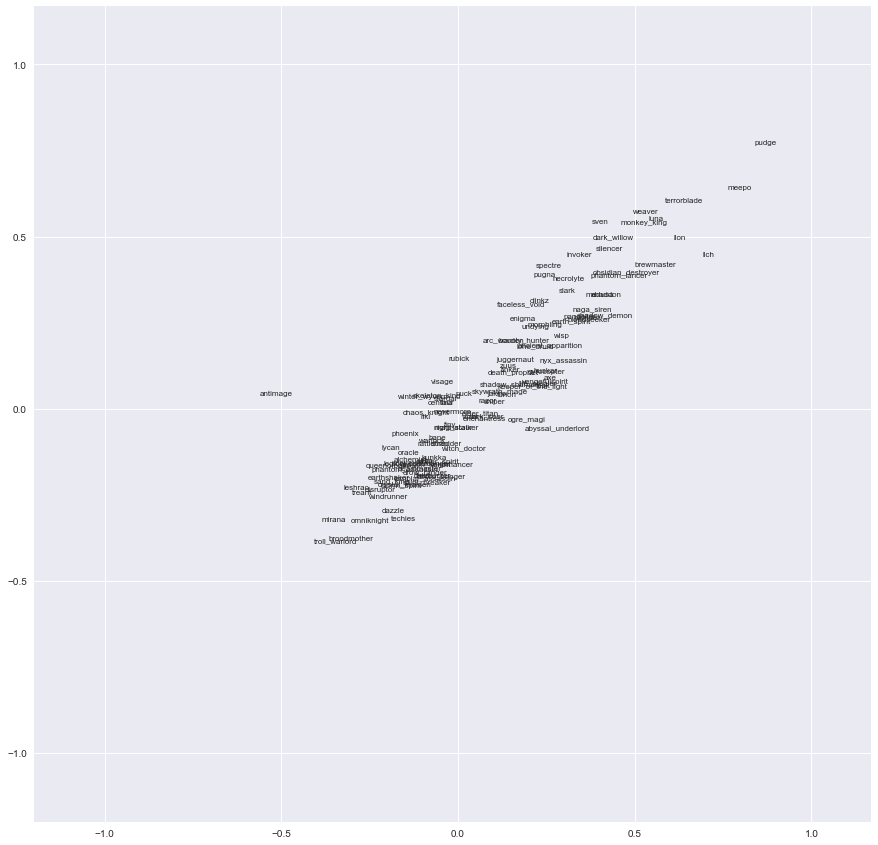

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
red_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/dire_heroes_embedding/embedding_weights')

radiant_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/radiant_heroes_embedding/embedding_weights')

for champ_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    red_vector = np.zeros(len(vocab))
    red_vector[champ_index] = 1
    radiant_vector = np.zeros(len(vocab))
    radiant_vector[champ_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    red_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    radiant_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(radiant_embedding_xy[0],
           radiant_embedding_xy[3],
           champ_list[champ_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.ylim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.show() 

### Save a trained model later exploration, or for on-demand prediction of test cases

In [20]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "radiant_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['radiant_champs'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    
    features = {'radiant_champs':radiant_heroes, 'dire_heroes': dire_heroes}
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [21]:
export_dir = os.path.join('trained_models','dnn_models')
trained_dnn_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/dnn_models/1554789124'